In [6]:
#/usr/bin/env python
import numpy as np
import pylab as pl
import subprocess as sp
#import source_redshift_dist as srd
import healpy as hp
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
import input
import os
from scipy.integrate import quad
from scipy.interpolate import interp1d



H0 = 71.0
Om0=0.2648
Ob0=0.044792699861138666
ncosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=Ob0)

rho_crit = ncosmo.critical_density0.to(u.solMass/u.Mpc/u.Mpc/u.Mpc).value/ncosmo.h/ncosmo.h #M_sun Mpc^-3 *h*h
vc = 2.998e5 #km/s
G = 4.3011790220362e-09 # Mpc/h (Msun/h)^-1 (km/s)^2
mp      = 2.6*10**9*ncosmo.h                                   # in Msun/h

########################### Mass Maps ################################
path_out = 'IA-infusion/SkySim5000/kappa/'
path_in = '/global/cfs/cdirs/lsst/groups/CS/mass_sheets/'
directory_contents = os.listdir(path_in)




In [7]:
def total_area(x_in,y_in):
    x_down = x_in[:-1]
    x_up = x_in[1:]
    y_down = y_in[:-1]
    y_up = y_in[1:]

    area_array = (y_down+y_up)*(x_up-x_down)/2.0

    return np.sum(area_array)


def cal_pdz(fname, z_in,col):

    #zs,dist1 = np.loadtxt("./data/source_distribution.txt",comments='#',usecols=(0,1),unpack=True)
    zs,dist1 = np.loadtxt(fname,comments='#',usecols=(0,col),unpack=True)
    dist1_normal = dist1/total_area(zs,dist1)
    # dist1_normal = dist1

    #np.savetxt("./data/srd_normed.dat",np.transpose(np.array([zs,dist1_normal])),fmt="%.6e")

    # f1 = interp1d(zs[::-1], dist1_normal[::-1], kind='cubic',bounds_error=False, fill_value=0.0)
    f1 = interp1d(zs[::-1], dist1_normal[::-1], kind='linear',bounds_error=False, fill_value=0.0)
    #f1 = interp1d(zs, dist1_normal, kind='linear',fill_value="extrapolate")

    return f1(z_in)

def wfunc_all(fname, zl,col):
    Dc_l = ncosmo.comoving_distance(zl).value*ncosmo.h
    cfactor = 4.0*np.pi*G/vc**2*(1.0+zl)/Dc_l


    zs_list = np.linspace(0.001,4.0,1000)
    #zs_list = np.logspace(-3,0.6,100)
    dzs = zs_list[1]-zs_list[0]
    total_wfunc = 0.0

    for zs in zs_list:
        if (zs<zl):
            continue

        Dc_s = ncosmo.comoving_distance(zs).value*ncosmo.h
        Dc_ls = Dc_s - Dc_l

        tmp = dzs*cal_pdz(fname, zs,col)*Dc_ls/Dc_s
        total_wfunc = total_wfunc + tmp

    #res = cfactor/afactor*total_wfunc
    res = cfactor*total_wfunc

    return res

def kappa_sl_ss(filename,zl,zs):

    Dc_l = ncosmo.comoving_distance(zl).value*ncosmo.h
    Dc_s = ncosmo.comoving_distance(zs).value*ncosmo.h
    Dc_ls = Dc_s - Dc_l

    sdens = np.fromfile(filename, dtype="<f")
    sdens_arc = sdens#/np.deg2rad(1.0)**2.0#*3.0462e-4 # 1 degree^2 = 3.0462e-4 steradian
    sdens_arc*=mp
    sdens_arc_normal = (sdens_arc-sdens_arc.mean()*8.0) # factor of 8.0 corrects for mean computed over all 8 octants

    #-----------------------
    # Results 2
    cfactor = 4.0*np.pi*G/vc**2
    res = cfactor*(1.0+zl)/Dc_l*Dc_ls/Dc_s*sdens_arc_normal
    print('Kernel = ', zl, zs, cfactor*(1.0+zl)/Dc_l*Dc_ls/Dc_s)
    return res

def kappa_sl_ms(filename,fname,zl,col):

    sdens = np.fromfile(filename, dtype="<f")
    sdens_arc = sdens#/np.deg2rad(1.0)**2.0#*3.0462e-4 # 1 degree^2 = 3.0462e-4 steradian
    sdens_arc*=mp
    sdens_arc_normal = (sdens_arc-sdens_arc.mean()*8.0) # factor of 8.0 corrects for mean computed over all 8 octants

    res = wfunc_all(fname, zl,col)*sdens_arc_normal

    #print(filename, zl, wfunc_all(fname, zl,col))

    return res



In [1]:
# Set redshift arrays:
zfile=np.loadtxt("z2ts.txt",delimiter=',')
snaplist = zfile[0:58,1].astype(int)
zsnap=zfile[0:58,0]
print(snaplist[0:58])
#print(zsnap)
dllow = np.empty((len(zsnap), 2), dtype=np.float)
dlup  = np.empty_like(dllow)
dllen = np.empty_like(dllow)


# construct the lens plane boundaries from SkySim5000, with shells 114 Mpc thick (=  114*h Mpc/h) 
for plane in range(0,58):
    dllow[plane,1] = plane*110.7#*ncosmo.h
    dlup[plane,1] = (plane+1)*110.7#*ncosmo.h
    #print(plane, dllow[plane,1], dlup[plane,1])

    dllow[plane,0] = z_at_value(ncosmo.comoving_distance, dllow[plane,1]*u.Mpc) if dllow[plane,1] > 0.0 else 0.0
    dlup[plane,0]  = z_at_value(ncosmo.comoving_distance,  dlup[plane,1]*u.Mpc)

    # could use the exact z edge values provided by the z2ts.txt file, instead of the z_at_value calculation, 
    # which gives slightly different answers.
    
# Computing the Lens Planes (Distance Average)
for i, (d1, d2) in enumerate(zip(dllow, dlup)):

    dllen[i, 0]  = quad( lambda z: z * ncosmo.comoving_distance(z).value, dllow[i, 0], dlup[i, 0] )[0]
    dllen[i, 0] /= quad( lambda z:     ncosmo.comoving_distance(z).value, dllow[i, 0], dlup[i, 0] )[0]
    dllen[i, 1]  = ncosmo.comoving_distance(dllen[i, 0]).value

print( "Plane list:     Dl_           Lens             Dl^      [all units in Mpc, not Mpc/h]"  )


for d1, dl, d2 in zip(dllow[:,1], dllen[:,1], dlup[:,1]):

    print("           {0: >10.4f}     {1: >10.4f}      {2: >10.4f} ".format(d1, dl, d2 ))


    
    
#for plane in range(0,29):
#    print(dlup[plane,0], dllow[plane,0])
print('***')
    
rds_upper = np.zeros_like(dlup[:,0])
rds_lower = np.zeros_like(dlup[:,0])


for plane in range(0,58):
    rds_upper[plane], rds_lower[plane] = [dlup[57-plane,0], dllow[57-plane,0]]

#-----
# Get lens redshifts, either from geometry:
zl_list = (3.0/4.0)*(rds_upper**4-rds_lower**4)/(rds_upper**3-rds_lower**3)
#... or from the partice distribution:
tmp=np.loadtxt("z_or_skysim.txt")
zlens_exact=np.zeros_like(tmp)
for plane in range(0,57):
    zlens_exact[plane]=tmp[56-plane]
zlens_exact = zlens_exact[:57] 
    
print( "Plane list:     z^       z_               zl_geo             zl_file             zl_ana"  )
for plane in range(0,57):
    print(rds_upper[plane], rds_lower[plane], zl_list[plane],zlens_exact[plane], dllen[57-plane, 0] )

#Mean_r = (r_max^4 - r_min^4)/(r_max^3 - rmin^3)*(3/4)
#zl_list = 0.5*(rds_lower+rds_upper)


#print(zlens_exact)

NameError: name 'np' is not defined

In [4]:
#input.kappaDir+"kappa_tomo"+np.str(1)+".fits"

Found these maps in the directory: ['density_map_475_dens.bin' 'density_map_464_dens.bin'
 'density_map_453_dens.bin' 'density_map_442_dens.bin'
 'density_map_432_dens.bin' 'density_map_421_dens.bin'
 'density_map_411_dens.bin' 'density_map_401_dens.bin'
 'density_map_392_dens.bin' 'density_map_382_dens.bin'
 'density_map_373_dens.bin' 'density_map_365_dens.bin'
 'density_map_355_dens.bin' 'density_map_347_dens.bin'
 'density_map_338_dens.bin' 'density_map_331_dens.bin'
 'density_map_323_dens.bin' 'density_map_315_dens.bin'
 'density_map_307_dens.bin' 'density_map_300_dens.bin'
 'density_map_293_dens.bin' 'density_map_286_dens.bin'
 'density_map_279_dens.bin' 'density_map_272_dens.bin'
 'density_map_266_dens.bin' 'density_map_259_dens.bin'
 'density_map_253_dens.bin' 'density_map_247_dens.bin'
 'density_map_241_dens.bin' 'density_map_235_dens.bin'
 'density_map_230_dens.bin' 'density_map_224_dens.bin'
 'density_map_219_dens.bin' 'density_map_213_dens.bin'
 'density_map_208_dens.bin' 'd

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
applied mask


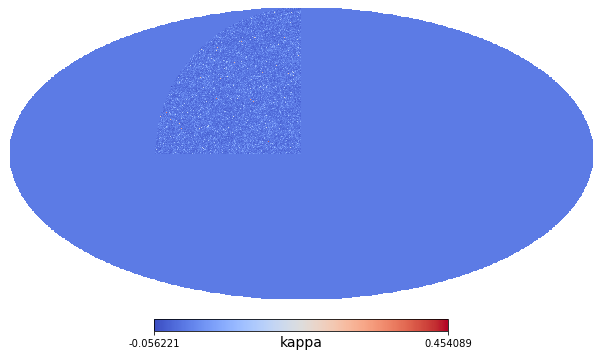

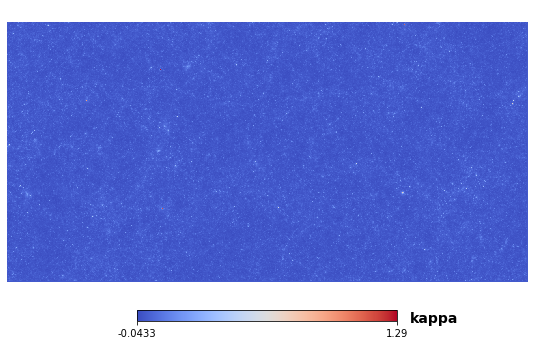

Saved kappa
density_map_475_dens.bin 0.018746 1.1069 1
Kernel =  0.018746 1.1069 1.0701545174496937e-20
Got lens 0.018746
density_map_464_dens.bin 0.040929 1.1069 2
Kernel =  0.040929 1.1069 4.898079942042506e-21
Got lens 0.040929
density_map_453_dens.bin 0.063221 1.1069 3
Kernel =  0.063221 1.1069 3.1660508859789008e-21
Got lens 0.063221
density_map_442_dens.bin 0.089164 1.1069 4
Kernel =  0.089164 1.1069 2.2383287284488063e-21
Got lens 0.089164
density_map_432_dens.bin 0.115479 1.1069 5
Kernel =  0.115479 1.1069 1.721078263449057e-21


In [ ]:
# Mass2Kappa_zslice
# For n(z) see further below;


#if __name__ == '__main__':
#
nside = 8192
npix = 12 * nside**2
noct = npix / 8 - nside

input_dir = input.baseDirectory
#mapsNames = sorted(directory_contents)[30:0:-1]
mapsNames = sorted(directory_contents)[57:0:-1]

mapsNames = np.array(mapsNames)
print("Found these maps in the directory:", mapsNames)
print("For a total of ",np.shape(mapsNames), "Maps")
print("*****")


# Start loop over source redshifts

#for zs in zsnap[1:]:
for zs in zsnap[29:]:



    # Initialise kappa maps:
    kpmap = np.zeros(npix)
    
    #planeIndexes = dlup[:,0]<=zs
    planeIndexes = np.flip(zlens_exact)<=zs
    #print(planeIndexes)

    maps_list = mapsNames[planeIndexes]
    tmp = np.fromfile(input.baseDirectory+maps_list[0],'<f')

    zid=0
    for filename in maps_list:
        #tmp = filename.split('_')
        #zid = int(tmp[4][:-4])
        #zl = zl_list[zid]
        #zl=dllen[zid, 0]
        #zl=zlens_exact[28-zid]
        zl=zlens_exact[56-zid]

        zid+=1

        print(filename, zl, zs, zid)
        if zl >= zs:
            continue

        kappa_z = kappa_sl_ss(input_dir+filename, zl, zs)
        kpmap = kpmap + kappa_z
        print("Got lens " +str(zl))

    # Convert to ring-ordered for sph.harmonic transforms:
    kpmap_ring = hp.reorder(kpmap, n2r = True)
    print("reordered map")

    #Apply mask
    if 'hpmap_weight' in locals():
        print("Mask already defined!")
    else:
        print("Reading in weight map for Mira Titan (Comment if already on disk...)")
        hpmap_weight = hp.fitsfunc.read_map('./IA-infusion/SkySim5000/FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)

    # show mask:
    #hp.mollview(hpmap_weight,
    #            unit=None, cmap=pl.cm.coolwarm,
    #            cbar=True, title='weight', norm=None
    #            , nest=False
    #            )
    #pl.show()

    kpmap_ring *= hpmap_weight
    print("applied mask")

    # show kappa:
    #np.max(kpmap_ring)
    hp.mollview(kpmap_ring,
                unit='kappa', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(kpmap_ring,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='kappa')
    pl.show()
    
    # save to file:
    #fname = input.kappaDir+np.str("{:5.4f}".format(ztab[0]))+"kappa.dat"
    fname = input.kappaDir+np.str("{:5.4f}".format(zs))+"kappa"

    np.save(fname, kpmap_ring)
    print("Saved kappa")

In [11]:
np.shape(tmp)

(58,)

In [ ]:
# Compute C_ell:
for zs in zsnap[28:]:

    print( "\nLoading convergence map and computing C_ell's: zs={:5.4f}\n".format(zs) )
    fname = input.kappaDir+np.str("{:5.4f}".format(zs))+"kappa.npy"
    kpmap_ring = np.load(fname)
    print("loaded kappa")

    # Compute C_ell:
    Cl = hp.sphtfunc.anafast(kpmap_ring, map2=None, nspec=None, lmax=5000, mmax=None, iter=1, alm=False, pol=False, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
    Cl *= 8.0
    print("Got C_ell")
    fname = input.kappaDir+np.str("{:5.4f}".format(zs))+"Cl.dat"
    np.savetxt(fname,Cl)
    print("Saved C_ell")
    



Loading convergence map and computing C_ell's: zs=1.0060

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.0552

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.1069

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.1520

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.2088

loaded kappa


In [6]:
zsnap[0:29]


array([0.    , 0.0245, 0.0502, 0.0749, 0.1008, 0.1279, 0.1538, 0.1837,
       0.2123, 0.2423, 0.2705, 0.3035, 0.3347, 0.3636, 0.4017, 0.4337,
       0.4714, 0.5022, 0.5391, 0.5777, 0.6184, 0.6557, 0.6948, 0.7358,
       0.7788, 0.824 , 0.8646, 0.9591, 1.006 ])

In [ ]:
# kappa2shear:

nside = 8192
npix = 12 * nside**2
noct = npix / 8 - nside

for zs in zsnap[29:30]:
#for zs in zsnap[28:29]:

    print( "\nLoading convergence map and computing shear maps for zs={:5.4f}\n".format(zs) )
    fname = input.kappaDir+np.str("{:5.4f}".format(zs))+"kappa.npy"
    kpmap_ring = np.load(fname)
    print("loaded kappa")

    # Compute shear:
    print("starting kappa map2alm")
    #alm_E = hp.sphtfunc.map2alm(kpmap_ring, lmax=5000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    alm_E = hp.sphtfunc.map2alm(kpmap_ring, lmax=16384, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)

    #alm_E = hp.sphtfunc.map2alm(hpmap, lmax=20000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    #alm_E = hp.sphtfunc.map2alm(hpmap_ring, lmax=5000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    #alm_T = alm_E*0.0;
    alm_B = alm_E*0.0;
    #
    print("Starting shear alm2map")
    #maps_QU = hp.alm2map_spin((alm_E, alm_B), nside, spin=2,lmax=5000,mmax=None)
    maps_QU = hp.alm2map_spin((alm_E, alm_B), nside, spin=2,lmax=16384,mmax=None)

    
    #maps_TQU = hp.sphtfunc.alm2map((alm_T, alm_E, alm_B), nside, lmax=32768, mmax=None, pixwin=True, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)
    #maps_TQU = hp.sphtfunc.alm2map((alm_T, alm_E, alm_B), nside, lmax=20000, mmax=None, pixwin=True, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)
    #maps_TQU = hp.sphtfunc.alm2map((alm_T, alm_E, alm_B), nside, lmax=20000, mmax=None, pixwin=False, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)
    #
    gamma1 = maps_QU[0]
    gamma2 = maps_QU[1]
    print("Got shear")
    fname1 = input.shearDir+np.str("{:5.4f}".format(zs))+"gamma1"
    fname2 = input.shearDir+np.str("{:5.4f}".format(zs))+"gamma2"
    np.save(fname1, gamma1)
    np.save(fname2, gamma2)
    print("Saved gamma")
    
    # show kappa:
    #np.max(kpmap_ring)
    hp.mollview(kpmap_ring,
                unit='kappa', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(kpmap_ring,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='kappa')
    pl.show()
    #
    # show gamma1:
    #np.max(kpmap_ring)
    hp.mollview(gamma1,
                unit='gamma1', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    hp.cartview(gamma1,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='shear1')
    pl.show()
    # show kappa:
    #np.max(kpmap_ring)
    hp.mollview(gamma2,
                unit='gamma2', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(gamma2,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='shear2')
    pl.show()


Loading convergence map and computing shear maps for zs=1.0552

loaded kappa
starting kappa map2alm


Found these maps in the directory: ['density_map_487_dens.bin' 'density_map_475_dens.bin'
 'density_map_464_dens.bin' 'density_map_453_dens.bin'
 'density_map_442_dens.bin' 'density_map_432_dens.bin'
 'density_map_421_dens.bin' 'density_map_411_dens.bin'
 'density_map_401_dens.bin' 'density_map_392_dens.bin'
 'density_map_382_dens.bin' 'density_map_373_dens.bin'
 'density_map_365_dens.bin' 'density_map_355_dens.bin'
 'density_map_347_dens.bin' 'density_map_338_dens.bin'
 'density_map_331_dens.bin' 'density_map_323_dens.bin'
 'density_map_315_dens.bin' 'density_map_307_dens.bin'
 'density_map_300_dens.bin' 'density_map_293_dens.bin'
 'density_map_286_dens.bin' 'density_map_279_dens.bin'
 'density_map_272_dens.bin' 'density_map_266_dens.bin'
 'density_map_259_dens.bin' 'density_map_253_dens.bin'
 'density_map_247_dens.bin' 'density_map_241_dens.bin'
 'density_map_235_dens.bin' 'density_map_230_dens.bin'
 'density_map_224_dens.bin' 'density_map_219_dens.bin'
 'density_map_213_dens.bin' 'd

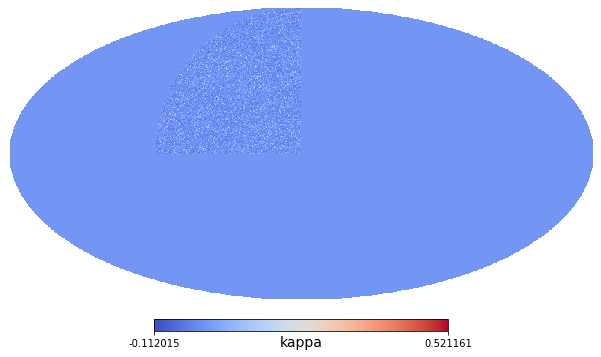

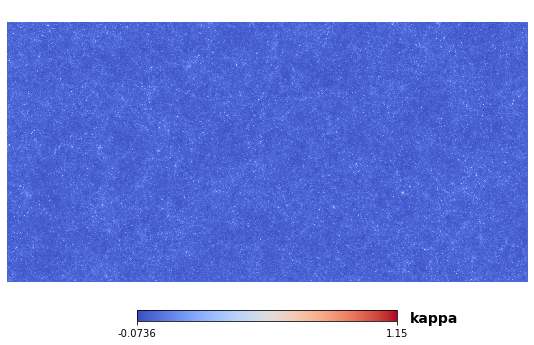

/tmp/ipykernel_33072/2436862013.py:95: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = "../../kappa/V0/kappa_tomo"+np.str(tomo)


Saved kappa


In [9]:
# Mass2Kappa_n(z)
nside = 8192
npix = 12 * nside**2
noct = npix / 8 - nside
zs=57

input_dir = input.baseDirectory
mapsNames = sorted(directory_contents)[58:1:-1] # use this one when there is a README file in the directory.
#mapsNames = sorted(directory_contents)[57:0:-1]

mapsNames = np.array(mapsNames)
print("Found these maps in the directory:", mapsNames)
print("For a total of ",np.shape(mapsNames), "Maps")
print("*****")


# Start loop over source redshifts

for tomo in range(5,6):
    
    print("Working on tomo", tomo)
    # Initialise kappa maps:
    kpmap = np.zeros(npix)
    
    #planeIndexes = dlup[:,0]<=zs
    planeIndexes = np.flip(zlens_exact)<=zs
    #print(planeIndexes)

    maps_list = mapsNames[planeIndexes]
    #tmp = np.fromfile(input.baseDirectory+maps_list[0],'<f')

    zid=0

    for filename in maps_list:
        zl=zlens_exact[56-zid]

        zid+=1

        print(filename, zl, zs, zid)
        #if zl >= zs:
        #    continue

        # kappa_z = kappa_sl_ss_2(input_dir+filename,zl,zs)
        #kappa_z = kappa_sl_ss(input_dir+filename, zl, zs)
        kappa_z = kappa_sl_ms(input_dir+filename,"./Euclid_dndz_fu08_bin1-5.dat",zl,tomo)
        kpmap = kpmap + kappa_z
        print("Got lens " +str(zl))
        #print(kappa_z)
        
    # Convert to ring-ordered for sph.harmonic transforms:
    kpmap_ring = hp.reorder(kpmap, n2r = True)
    print("reordered map")

    #Apply mask
    if 'hpmap_weight' in locals():
        print("Mask already defined!")
    else:
        print("Reading in weight map for Mira Titan (Comment if already on disk...)")
        hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)

    # show mask:
    #hp.mollview(hpmap_weight,
    #            unit=None, cmap=pl.cm.coolwarm,
    #            cbar=True, title='weight', norm=None
    #            , nest=False
    #            )
    #pl.show()

    kpmap_ring *= hpmap_weight
    print("applied mask")

    # show kappa:
    #np.max(kpmap_ring)
    hp.mollview(kpmap_ring,
                unit='kappa', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(kpmap_ring,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='kappa')
    pl.show()
    
    # save to file, in .npy format:
    #fname = input.kappaDir+"kappa_tomo"+np.str(tomo)
    fname = "../../kappa/V0/kappa_tomo"+np.str(tomo) 

    np.save(fname, kpmap_ring)
    print("Saved kappa")


In [10]:
# Compute C_ell:
for tomo in range(5,6):

    print( "\nLoading convergence map and computing C_ell's: tomo="+np.str(tomo))
    fname = "../../kappa/V0/kappa_tomo"+np.str(tomo)+".npy" 
    #fname = "../../kappa/V0/kappa_tomo"+np.str(tomo)+"_V3.npy" 
    kpmap_ring = np.load(fname)
    print("loaded kappa")

    # Compute C_ell:
    Cl = hp.sphtfunc.anafast(kpmap_ring, map2=None, nspec=None, lmax=5000, mmax=None, iter=1, alm=False, pol=False, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
    Cl *= 8.0
    print("Got C_ell")
    fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+".dat"
    #fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+"_V3.dat"
    np.savetxt(fname,Cl)
    print("Saved C_ell")
    


/tmp/ipykernel_33072/2878850223.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print( "\nLoading convergence map and computing C_ell's: tomo="+np.str(tomo))
/tmp/ipykernel_33072/2878850223.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = "../../kappa/V0/kappa_tomo"+np.str(tomo)+".npy"



Loading convergence map and computing C_ell's: tomo=5
loaded kappa
Got C_ell


/tmp/ipykernel_33072/2878850223.py:14: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+".dat"


Saved C_ell


In [18]:
# Mass2Kappa_n(z) using SimulLens code:
nside = 8192
npix = 12 * nside**2
noct = npix / 8 - nside
zs=57

input_dir = input.baseDirectory
mapsNames = sorted(directory_contents)[58:1:-1] # use this one when there is a README file in the directory.
#mapsNames = sorted(directory_contents)[57:0:-1]

mapsNames = np.array(mapsNames)
#print("Found these maps in the directory:", mapsNames)
#print("For a total of ",np.shape(mapsNames), "Maps")
#print("*****")
nl = np.shape(mapsNames)[0]
Norm = 1.0

for tomo in range(1,6):

    print('*** Working on tomo' , tomo, '***')
    
    #----
    # Read the n(z) files
    zs,Nz = np.loadtxt("./Euclid_dndz_fu08_bin1-5.dat",comments='#',usecols=(0,tomo),unpack=True)
    #Nz_normal = Nz/total_area(zs,Nz)
    nzbins = np.shape(zs)[0]

    #----
    # compute the Jacobian, dchi/dz:
    chi_file = np.zeros(nzbins)
    for i in range(0,nzbins):
        chi_file[i] = ncosmo.comoving_distance(zs[i]).value*ncosmo.h
        #print(i,zs[i], chi_file[i])

    #----
    # compute the dchi:
    dchi = np.zeros(nzbins)
    for i in range(0,nzbins-1):
        dchi[i] = chi_file[i+1]-chi_file[i]

    dchi[nzbins-1] = dchi[nzbins-2]


    # Initialise kappa maps:
    kpmap = np.zeros(npix)

    #Loop over the lenses:
    zid=0
    for filename in mapsNames:
        #tmp = filename.split('_')
        #zid = int(tmp[4][:-4])
        #zl = zl_list[zid]
        #zl=dllen[zid, 0]
        #zl=zlens_exact[28-zid]
        zl=zlens_exact[56-zid]
        chi_l = ncosmo.comoving_distance(zl).value*ncosmo.h

        zid+=1

        #find minimum for the Nz integration
        zmin = 0
        for ii in range(0,nzbins):
            if(zs[ii] > zl):
                zmin = ii
                break

        # Get integal over sources
        gw = 0
        for ii in range(zmin, nzbins):
            gw = gw + Nz[ii]*(1.0 - chi_l/chi_file[ii])*dchi[ii]     


        #-----
        # Get Kernel
        kernel = 3./2. * Om0 * (3000/10240)/(3e3**2)*chi_l * (1+zl) * gw * Norm
        #print('Kernel4 = ', kernel)

        #print(zl, zmin, zs[zmin], Nz[zmin], gw, kernel, filename)

        # Get particle_count planes:
        massmap = np.fromfile(input.baseDirectory+filename, dtype="<f")
        
        #Convert to mass planes, in M_sun/h
        #massmap *= mp 

        #Convert to overdensity maps, 
        massmap-=np.mean(massmap)*8

        # Integrate:
        #kpmap = kpmap + massmap*kernel

    continue    
        
    # Convert to ring-ordered for sph.harmonic transforms:
    kpmap_ring = hp.reorder(kpmap, n2r = True)
    print("reordered map")

    #Apply mask
    if 'hpmap_weight' in locals():
        print("Mask already defined!")
    else:
        print("Reading in weight map for Mira Titan (Comment if already on disk...)")
        hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)


    kpmap_ring *= hpmap_weight
    print("applied mask")

    
    # show kappa:
    hp.mollview(kpmap_ring,
                unit='kappa', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(kpmap_ring,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='kappa')
    pl.show()
    
    
    fname = "../../kappa/V0/kappa_tomo"+np.str(tomo)+"_V3" 

    np.save(fname, kpmap_ring)
    print("Saved kappa")




*** Working on tomo 1 ***
0.018746 2 0.025 0.043675671 141.11194283902205 0.00010406845095241647 density_map_487_dens.bin
0.040929 4 0.045 0.057694448 123.3921761241848 0.00020209992099076197 density_map_475_dens.bin
0.063221 6 0.065 0.068766169 107.71728966723832 0.00027707844367207054 density_map_464_dens.bin
0.089164 9 0.095 0.082640752 91.61479306579602 0.0003386290497717983 density_map_453_dens.bin
0.115479 12 0.125 0.094688125 77.17816275020085 0.00037627555652623 density_map_442_dens.bin
0.141379 14 0.145 0.10210442 64.6545396724474 0.00039267633430662763 density_map_432_dens.bin
0.170235 17 0.175 0.11263836 52.37970798008667 0.00039026793411244253 density_map_421_dens.bin
0.198763 20 0.205 0.12271404 41.82450513255839 0.00037036205899014117 density_map_411_dens.bin
0.22817 23 0.235 0.13252069 32.43941300056939 0.0003356159671384345 density_map_401_dens.bin
0.257155 26 0.265 0.14218409 24.549334652000578 0.00029107666527017394 density_map_392_dens.bin
0.287749 29 0.295 0.1517865

In [ ]:
# Compute C_ell:
Cl = hp.sphtfunc.anafast(kpmap_ring, map2=None, nspec=None, lmax=5000, mmax=None, iter=1, alm=False, pol=False, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
Cl *= 8.0
print("Got C_ell")
#fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+".dat"
fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+"_V3.dat"
np.savetxt(fname,Cl)
print("Saved C_ell")



In [7]:
input_dir = input.baseDirectory
mapsNames = sorted(directory_contents)[58:1:-1] # use this one when there is a README file in the directory.
#mapsNames = sorted(directory_contents)[57:0:-1]

mapsNames = np.array(mapsNames)

zid=0
for filename in mapsNames:
    #tmp = filename.split('_')
    #zid = int(tmp[4][:-4])
    #zl = zl_list[zid]
    #zl=dllen[zid, 0]
    #zl=zlens_exact[28-zid]
    zl=zlens_exact[56-zid]
    chi_l = ncosmo.comoving_distance(zl).value*ncosmo.h

    zid+=1

    #find minimum for the Nz integration
    zmin = 0
    for ii in range(0,nzbins):
        if(zs[ii] > zl):
            zmin = ii
            break

    # Get integal over sources
    gw = 0
    for ii in range(zmin, nzbins):
        gw = gw + Nz[ii]*(1.0 - chi_l/chi_file[ii])*dchi[ii]     

    print(zl, zmin, zs[zmin], Nz[zmin], gw)


NameError: name 'nzbins' is not defined

array([1.00000000e-03, 1.08733567e-03, 1.18229887e-03, 1.28555573e-03,
       1.39783061e-03, 1.51991108e-03, 1.65265354e-03, 1.79698915e-03,
       1.95393040e-03, 2.12457823e-03, 2.31012970e-03, 2.51188643e-03,
       2.73126372e-03, 2.96980048e-03, 3.22917000e-03, 3.51119173e-03,
       3.81784403e-03, 4.15127800e-03, 4.51383266e-03, 4.90805127e-03,
       5.33669923e-03, 5.80278345e-03, 6.30957344e-03, 6.86062429e-03,
       7.45980152e-03, 8.11130831e-03, 8.81971488e-03, 9.58999061e-03,
       1.04275389e-02, 1.13382350e-02, 1.23284674e-02, 1.34051824e-02,
       1.45759330e-02, 1.58489319e-02, 1.72331091e-02, 1.87381742e-02,
       2.03746853e-02, 2.21541221e-02, 2.40889673e-02, 2.61927934e-02,
       2.84803587e-02, 3.09677100e-02, 3.36722958e-02, 3.66130884e-02,
       3.98107171e-02, 4.32876128e-02, 4.70681656e-02, 5.11788955e-02,
       5.56486388e-02, 6.05087501e-02, 6.57933225e-02, 7.15394265e-02,
       7.77873705e-02, 8.45809828e-02, 9.19679199e-02, 1.00000000e-01,
      